<a href="https://colab.research.google.com/github/giovannimmiranda/DL_20-06_GMM/blob/main/DL_20_06_Miranda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning Exam - 20/06/2024**


Giovanni Michele Miranda,  507567

# General Information
We are given a dataset containing 186 images which are categorized into three classes, depending on the main object they contain. The following inputs are available:
1. input image, a 227 × 227 × 3 real-valued tensor. The last dimension denotes the number of input channels (RGB). Each pixel is a value in [0, 255];
2. image label, integer in the set {1,2,3} denoting one of three possible objects an image can contain. There are 63, 62, and 61 images belonging to the class 1, 2 and 3, respectively;
3. image bounding box, four integers x1, y1, x2, y2 in the range 1–227, where (x1, y1) and (x2, y2) are the bottom-left and the top-right corners of the box containing the object, respectively.

**TASK**: Design a deep neural network model to predict the class of an image along with the corresponding bounding box coordinates.

## Type of tasks
The requirements induce us to implement two different types of task:


1.   **Multiclass Classification**: we are required to predict the exact class of an image among the three of the proposed dataset.
2.   **Regression**: we are required to predict the exact bounding box coordinate values, which also come along with the images. In simple terms, we need to predict the box with the smallest measure within which all the points of the reference image lie.



## Architecture Proposed
The idea that came to mind is to use a convolutional neural network (CNN) as the reference model. CNNs are well-known for their ability to handle spatial relationships and features within images, such as edges and borders.
More deeper insights about the created model will be given later in the specific sections.

# Input

**Import libraries**: In this section as first I will import the libraries needed later for the construction and operational tasks of the architecture


In [29]:
import numpy as np
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

**Import Data**: In the second step, I import the dataset using the code provided by the professor on the course's webpage.

In [16]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/giovannimmiranda/DL_20-06_GMM/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"
#Then use the following lines to read it:
import pickle as pk
with open(data_path, 'rb') as f:
  data = pk.load(f)
images = data['imgs']
y = data['labels']
labels = y[:,0]
bboxes = y[:,1:]

The dataset consists of three inputs that need to be preprocessed to ensure they have the correct *shape* for the architecture to properly process and utilize them.

**Pixel Normalization**: As first normalization step, I have normalized images pixels from former [0,255] interval into the **bounded interval [0,1]**. This process ensures a faster convergence and prevent (at least as very first step) large gradients.

This is done by subtracting the minimum pixel value from each pixel and then divide by the range (maximum pixel value **-** minimium pixel value).

In [17]:
images = (images - np.min(images)) / (np.max(images) - np.min(images))

**Image Balancing**: In my implementation I have suggested to equally balance the number of images in the three classes of the dataset. In fact our dataset was proposed with:

*   Class 1: 63 images
*   Class 2: 62 images
*   Class 3: 61 images.

My goal is to balance them all, by removing randomly and respectively two and one images for class 1 and class 2.

In [18]:
label_to_remove_c1 = 1  # First class
label_to_remove_c2 = 2  # Second class

# Here we check that there are enough images in the set
if labels.shape[0] > 184 and images.shape[0] > 184:
    # Find indices of images with the specified labels
    indices_to_remove_c1 = np.where(labels == label_to_remove_c1)[0]
    indices_to_remove_c2 = np.where(labels == label_to_remove_c2)[0]

    # Randomly select two indices from the first class
    random_indices_c1 = random.sample(list(indices_to_remove_c1), 2)
    # Randomly select one index from the second class
    random_indices_c2 = random.sample(list(indices_to_remove_c2), 1)

    # Remove the selected images and their corresponding labels
    images = np.delete(images, random_indices_c1, axis=0)
    labels = np.delete(labels, random_indices_c1, axis=0)
    # Adjust the second class index due to the removal of the first class indices
    random_indices_c2 = [i - np.sum(random_indices_c1 < i) for i in random_indices_c2]
    images = np.delete(images, random_indices_c2, axis=0)
    labels = np.delete(labels, random_indices_c2, axis=0)

    print(f"Removed images at indices: {random_indices_c1} from class 1 and {random_indices_c2} from class 2")
    print(f"New dataset size: {images.shape[0]} images, {labels.shape[0]} labels")
else:
    print(f"The dataset is already set! It has {images.shape[0]} images.")
    unique_labels, counts = np.unique(labels, return_counts=True)
    print("\nNow the dataset is balanced:")
    for label, count in zip(unique_labels, counts):
      print(f"\n Class {label}: {count} images")

Removed images at indices: [48, 17] from class 1 and [95] from class 2
New dataset size: 183 images, 183 labels


In [19]:
images.shape

(183, 227, 227, 3)

In [20]:
batch_size = 5
bboxes[:batch_size]

array([[ 23,  42, 206, 199],
       [ 13,  70, 219, 160],
       [  8,  42, 221, 200],
       [ 22,  67, 218, 158],
       [ 15,  56, 212, 156]])

**Bounding Box Normalization**: In the following cell, I want to normalize bounding boxes in a fixed bound [0,1], for a similar reason as for image pixels, very large values can indeed create problems with gradients.

The normalization addresses this problem and is basically harmless, since at the end of the training process we can restore the original sizes and correctly visualizes the boxes along with the images.

In [21]:
image_width_height = 227

# Bounding Boxes can be thought of like (x1, y1, x2, y2).
bboxes_normalized = bboxes.astype(float)
bboxes_normalized[:, 0] /= image_width_height  # Normalize x1
bboxes_normalized[:, 1] /= image_width_height  # Normalize y1
bboxes_normalized[:, 2] /= image_width_height  # Normalize x2
bboxes_normalized[:, 3] /= image_width_height  # Normalize y2

print(f"Printing first {batch_size} normalized bounding boxes:")
print(bboxes_normalized[:batch_size])

#Removing images at indices [47, 36] from class 1 (chosen at random) and [115] (chosen at random) from class 2
removed_indices = [47, 36, 115]

# Remove corresponding bounding boxes
bboxes_normalized = np.delete(bboxes_normalized, removed_indices, axis=0)

# Now `bboxes_normalized` contains the updated bounding box data after removal
print("Updated number of bounding boxes:", len(bboxes_normalized))
print(bboxes_normalized.shape)

Printing first 5 normalized bounding boxes:
[[0.10132159 0.18502203 0.90748899 0.87665198]
 [0.05726872 0.30837004 0.96475771 0.70484581]
 [0.03524229 0.18502203 0.97356828 0.88105727]
 [0.0969163  0.29515419 0.96035242 0.69603524]
 [0.0660793  0.24669604 0.9339207  0.68722467]]
Updated number of bounding boxes: 183
(183, 4)


**Labels reshaping**: Here I add an additional processing step, which brings the adjustement of the labels interval from [1,3] to [0,2]. This choice is forced by the sparse categorical cross entropy (our classification loss), which just operates with labels within that ranges (starting from 0).

In [22]:
labels = labels - 1

Now the input is set for all those operations required for the training section.

##Data Preparation
The code begins by splitting the dataset into training and validation sets using train_test_split. It divides the images, classification labels, and normalized bounding boxes, with 20% of the data reserved for validation. The random state is set to 42 for reproducibility.

##TensorFlow Dataset Creation
Next, TensorFlow datasets are created from the training and validation data using tf.data.Dataset.from_tensor_slices. The datasets are then shuffled (for training) and batched for efficient processing. The batch size is set to 16.

##Residual Block Definition
The code defines a function for a residual block, which includes convolutional layers with L2 regularization, batch normalization, and ReLU activation functions. The residual block also includes a shortcut connection to add the input to the output, ensuring gradient flow during training.

##Model Architecture
The model architecture is defined with an input layer corresponding to the shape of the training images. The input is passed through a series of residual blocks with increasing filter sizes and max pooling layers to reduce the spatial dimensions. The final features are flattened and passed through a dense layer with L2 regularization.

##Output Layers
The model has two output branches: a classification branch with a softmax activation for classifying images into three classes, and a regression branch with a linear activation for predicting bounding box coordinates (x, y, width, height).

##Model Compilation
The model is compiled with the Adam optimizer, which includes gradient clipping to prevent exploding gradients. It uses sparse_categorical_crossentropy loss for the classification output and mean_squared_error loss for the regression output. The metrics tracked are accuracy for classification and mean squared error for regression.

##Model Training
The model is trained for 40 epochs with early stopping based on validation loss, which halts training if the validation loss does not improve for three consecutive epochs. Early stopping also restores the best weights observed during training.

##Model Evaluation
Finally, the model is evaluated on the validation set, and the classification and regression losses are printed. This evaluation helps to understand the model's performance on unseen data.

In [26]:
X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox = train_test_split(images, labels, bboxes_normalized, test_size=0.2, random_state=42)

seed = random.randint(0, 1000)
num_classes = 3
batch_size = 16


# Define a Residual Block with L2 regularization
def residual_block(x, filters, kernel_size=3, stride=1, l2_reg=0.001):  # Add L2 regularization parameter
    shortcut = x

    initializer = tf.keras.initializers.HeUniform(seed=seed)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Add shortcut (identity mapping)
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                          kernel_initializer=initializer)(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# Define the model with residual blocks along with regularization
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
inputs = tf.keras.Input(shape=input_shape)
x = residual_block(inputs, 32, l2_reg=0.001)  # Apply L2 regularization to residual blocks
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64, l2_reg=0.001)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 128, l2_reg=0.001)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 256, l2_reg=0.001)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001),
                          kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(x)  # L2 on Dense layer


# Classification branch
outputs_cls = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_output')(x)

# Regression branch
outputs_reg = tf.keras.layers.Dense(4, activation='linear', name='regression_output')(x)  # Assuming 4 for bounding box (x, y, w, h)

# Define the model with multiple outputs
model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_reg])

# Compile the model with separate loss functions for each output
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)  # Add gradient clipping

model.compile(optimizer=optimizer,
              loss={'classification_output': 'sparse_categorical_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'classification_output': 'accuracy', 'regression_output': 'mse'})


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, mode='min', restore_best_weights=True)


# Train the model with combined data
history = model.fit(X_train, {'classification_output': y_train_cls, 'regression_output': y_train_bbox},
                    epochs=40, batch_size=batch_size, validation_data=(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox}))

# Evaluate the model
losses = model.evaluate(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox})
#print("Total Loss:", losses[0]) # Access the total loss
print("Classification Loss:", losses[1]) # Access the classification loss
print("Regression Loss:", losses[2]) # Access the regression loss

Epoch 1/40
10/10 [==============================] - 9s 102ms/step - loss: 28530.4805 - classification_output_loss: 56.7591 - regression_output_loss: 28470.3535 - classification_output_accuracy: 0.2740 - regression_output_mse: 28470.3535 - val_loss: 648318.4375 - val_classification_output_loss: 753.5846 - val_regression_output_loss: 647561.4375 - val_classification_output_accuracy: 0.4054 - val_regression_output_mse: 647561.4375
Epoch 2/40
10/10 [==============================] - 0s 42ms/step - loss: 24.3352 - classification_output_loss: 7.1721 - regression_output_loss: 13.6524 - classification_output_accuracy: 0.3836 - regression_output_mse: 13.6524 - val_loss: 981911.8125 - val_classification_output_loss: 615.4998 - val_regression_output_loss: 981292.6250 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 981292.6250
Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 6.2969 - classification_output_loss: 1.2103 - regression_output_loss: 1.45

In [28]:
# Assuming X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox are already defined

seed = random.randint(0, 1000)
num_classes = 3
batch_size = 16

# Define a Residual Block with L2 regularization
def residual_block(x, filters, kernel_size=3, stride=1, l2_reg=0.001):
    shortcut = x

    initializer = tf.keras.initializers.HeUniform(seed=seed)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same',
                               kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
                               kernel_initializer=initializer)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Add shortcut (identity mapping)
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = tf.keras.layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same',
                                          kernel_initializer=initializer)(shortcut)
    x = tf.keras.layers.Add()([x, shortcut])
    x = tf.keras.layers.ReLU()(x)
    return x

# Function to create model with specified hyperparameters
def create_model(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.2, hidden_activation='relu', weight_reg='l2'):
    inputs = tf.keras.Input(shape=input_shape)
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
    x = residual_block(inputs, 32, l2_reg=0.001)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 64, l2_reg=0.001)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 128, l2_reg=0.001)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = residual_block(x, 256, l2_reg=0.001)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(256, activation=hidden_activation, kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(x)

    # Classification branch
    outputs_cls = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_output')(x)

    # Regression branch
    outputs_reg = tf.keras.layers.Dense(4, activation='linear', name='regression_output')(x)

    # Define the model with multiple outputs
    model = tf.keras.Model(inputs=inputs, outputs=[outputs_cls, outputs_reg])

    # Compile the model with separate loss functions for each output
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipvalue=0.5)
    model.compile(optimizer=optimizer,
                  loss={'classification_output': 'sparse_categorical_crossentropy', 'regression_output': 'mean_squared_error'},
                  metrics={'classification_output': 'accuracy', 'regression_output': 'mse'})
    return model




def random_search_multitask(X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox, param_grid, num_models=5, epochs=20, batch_size=16):
    best_score = 0
    best_model = None
    results = []

    # Randomly sample from the hyperparameter grid
    for _ in range(num_models):
        params = {key: random.choice(value) for key, value in param_grid.items()}
        print(f"Training model with params: {params}")

        model = create_model(X_train.shape[1:], num_classes=num_classes, **params)

        history = model.fit(X_train, {'classification_output': y_train_cls, 'regression_output': y_train_bbox},
                            epochs=epochs, batch_size=batch_size, validation_data=(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox}),
                            verbose=1)

        # Evaluate on validation data
        losses = model.evaluate(X_val, {'classification_output': y_val_cls, 'regression_output': y_val_bbox}, verbose=0)
        classification_loss = losses[1]  # Access classification loss
        regression_loss = losses[2]  # Access regression loss

        # Optionally, calculate classification metrics
        y_pred_cls = np.argmax(model.predict(X_val)[0], axis=1)
        accuracy = accuracy_score(y_val_cls, y_pred_cls)
        f1 = f1_score(y_val_cls, y_pred_cls, average='weighted')

        # Optionally, calculate regression metrics
        mse = mean_squared_error(y_val_bbox, model.predict(X_val)[1])

        # Calculate merged score
        merged_score = np.sqrt(accuracy * f1 * (((np.log(mse)) + 1) ** -1))

        results.append({
            'params': params,
            'classification_loss': classification_loss,
            'regression_loss': regression_loss,
            'accuracy': accuracy,
            'f1_score': f1,
            'mse': mse,
            'merged_score': merged_score
        })

        if merged_score > best_score:
            best_score = merged_score
            best_model = model

    return best_model, results

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [10**-3, 10**-2, 10**-1],
    'dropout_rate': [0.1, 0.2, 0.3],
    'num_layers': [2, 3, 4],  # Total number of layers in the model
    'filter_dim': [(3, 3), (5, 5)],  # Dimensions of convolutional filters
    'batch_size': [16, 32],
    'num_pooling_layers': [2, 3, 4],  # Number of pooling layers
    'padding': ['same', 'valid'],
}


# Perform random search for hyperparameters and evaluate
best_model, results = random_search_multitask(X_train, X_val, y_train_cls, y_val_cls, y_train_bbox, y_val_bbox, param_grid)

# Print results
for result in results:
    print(f"Params: {result['params']}")
    print(f"Classification Loss: {result['classification_loss']:.4f}, Regression Loss: {result['regression_loss']:.4f}")
    print(f"Accuracy: {result['accuracy']:.4f}, F1 Score: {result['f1_score']:.4f}, MSE: {result['mse']:.4f}")
    print(f"Merged Score: {result['merged_score']:.4f}")
    print("\n")

Training model with params: {'learning_rate': 0.1, 'dropout_rate': 0.1, 'hidden_activation': 'relu', 'weight_reg': 'l2'}
Epoch 1/40
10/10 [==============================] - 9s 99ms/step - loss: 33073678336.0000 - classification_output_loss: 36676.3125 - regression_output_loss: 33073645568.0000 - classification_output_accuracy: 0.2945 - regression_output_mse: 33073645568.0000 - val_loss: 21957122282300426690068742144.0000 - val_classification_output_loss: 480231232110592.0000 - val_regression_output_loss: 21957122282300426690068742144.0000 - val_classification_output_accuracy: 0.4054 - val_regression_output_mse: 21957122282300426690068742144.0000
Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 260380.5469 - classification_output_loss: 594.2404 - regression_output_loss: 257627.3906 - classification_output_accuracy: 0.2603 - regression_output_mse: 257627.3906 - val_loss: 78339701186944059834368.0000 - val_classification_output_loss: 352865419264.0000 - val_regress

<ipython-input-28-fffb71a26561>:104: RuntimeWarning: invalid value encountered in sqrt
  merged_score = np.sqrt(accuracy * f1 * (((np.log(mse)) + 1) ** -1))


Epoch 1/40
10/10 [==============================] - 10s 101ms/step - loss: 11567.1201 - classification_output_loss: 120.1414 - regression_output_loss: 11443.6045 - classification_output_accuracy: 0.3014 - regression_output_mse: 11443.6045 - val_loss: 6149211.0000 - val_classification_output_loss: 4956.8662 - val_regression_output_loss: 6144251.5000 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 6144251.5000
Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 29.9021 - classification_output_loss: 11.4622 - regression_output_loss: 14.9457 - classification_output_accuracy: 0.3356 - regression_output_mse: 14.9457 - val_loss: 8777262.0000 - val_classification_output_loss: 2040.2939 - val_regression_output_loss: 8775217.0000 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 8775217.0000
Epoch 3/40
10/10 [==============================] - 0s 41ms/step - loss: 8.8735 - classification_output_loss: 1.7100 - regression_output

<ipython-input-28-fffb71a26561>:104: RuntimeWarning: invalid value encountered in sqrt
  merged_score = np.sqrt(accuracy * f1 * (((np.log(mse)) + 1) ** -1))


Epoch 1/40
10/10 [==============================] - 9s 100ms/step - loss: 696806.5000 - classification_output_loss: 257.4589 - regression_output_loss: 696538.8750 - classification_output_accuracy: 0.2877 - regression_output_mse: 696538.8750 - val_loss: 3956232502493839360.0000 - val_classification_output_loss: 1874249216.0000 - val_regression_output_loss: 3956232502493839360.0000 - val_classification_output_accuracy: 0.4054 - val_regression_output_mse: 3956232502493839360.0000
Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 85.8632 - classification_output_loss: 3.0761 - regression_output_loss: 56.6619 - classification_output_accuracy: 0.3904 - regression_output_mse: 56.6619 - val_loss: 239404947412615168.0000 - val_classification_output_loss: 531777920.0000 - val_regression_output_loss: 239404947412615168.0000 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 239404947412615168.0000
Epoch 3/40
10/10 [==============================] - 0s 

<ipython-input-28-fffb71a26561>:104: RuntimeWarning: invalid value encountered in sqrt
  merged_score = np.sqrt(accuracy * f1 * (((np.log(mse)) + 1) ** -1))


Epoch 1/40
10/10 [==============================] - 9s 100ms/step - loss: 26528.4785 - classification_output_loss: 49.6362 - regression_output_loss: 26475.4570 - classification_output_accuracy: 0.3219 - regression_output_mse: 26475.4570 - val_loss: 1926745.7500 - val_classification_output_loss: 2151.9602 - val_regression_output_loss: 1924590.2500 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 1924590.2500
Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 21.6563 - classification_output_loss: 4.9590 - regression_output_loss: 13.1564 - classification_output_accuracy: 0.4110 - regression_output_mse: 13.1564 - val_loss: 543980.5000 - val_classification_output_loss: 497.9976 - val_regression_output_loss: 543478.9375 - val_classification_output_accuracy: 0.2973 - val_regression_output_mse: 543478.9375
Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 7.3116 - classification_output_loss: 1.1458 - regression_output_loss: 

<ipython-input-28-fffb71a26561>:104: RuntimeWarning: invalid value encountered in sqrt
  merged_score = np.sqrt(accuracy * f1 * (((np.log(mse)) + 1) ** -1))


Epoch 1/40
10/10 [==============================] - 9s 100ms/step - loss: 16.1204 - classification_output_loss: 3.0855 - regression_output_loss: 9.6388 - classification_output_accuracy: 0.2397 - regression_output_mse: 9.6388 - val_loss: 5.7826 - val_classification_output_loss: 1.4882 - val_regression_output_loss: 0.8986 - val_classification_output_accuracy: 0.2703 - val_regression_output_mse: 0.8986
Epoch 2/40
10/10 [==============================] - 0s 41ms/step - loss: 8.2025 - classification_output_loss: 1.2962 - regression_output_loss: 3.5107 - classification_output_accuracy: 0.5000 - regression_output_mse: 3.5107 - val_loss: 5.5661 - val_classification_output_loss: 1.4862 - val_regression_output_loss: 0.6847 - val_classification_output_accuracy: 0.2162 - val_regression_output_mse: 0.6847
Epoch 3/40
10/10 [==============================] - 0s 42ms/step - loss: 6.4748 - classification_output_loss: 0.9459 - regression_output_loss: 2.1339 - classification_output_accuracy: 0.5822 - reg

2/2 [==============================] - 0s 15ms/step


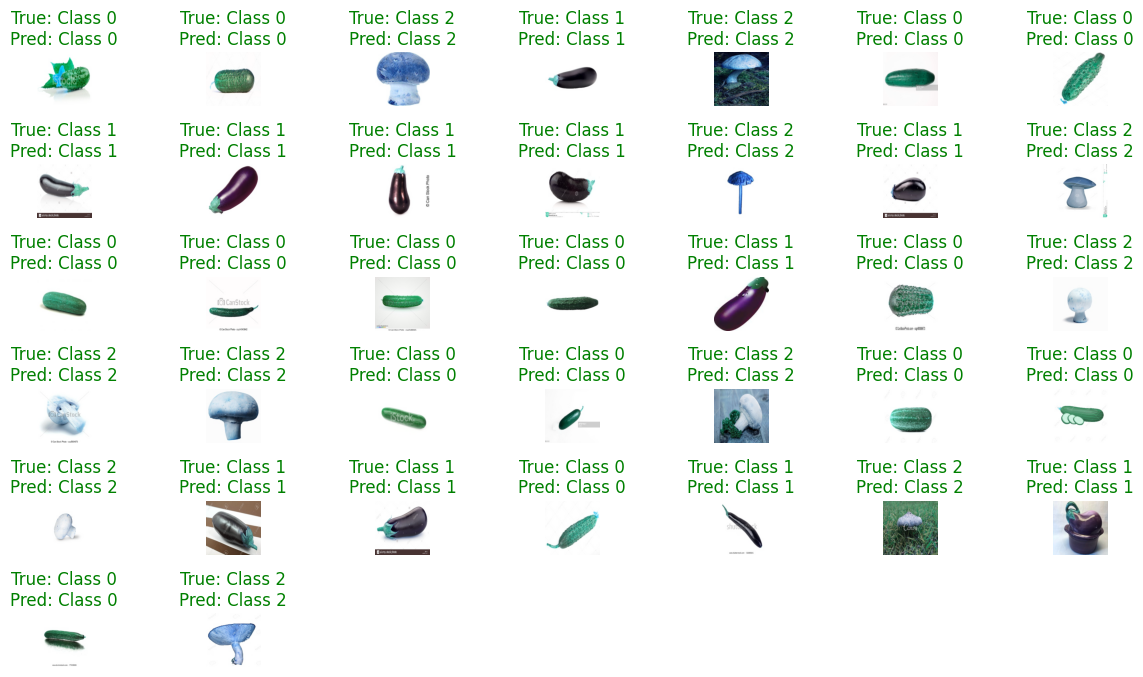

In [16]:
# Function to plot images with their predicted and true labels
def plot_images_with_labels(images, true_labels, pred_labels, class_names):
    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(7, 7, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(f'True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}', color='green' if true_labels[i] == pred_labels[i] else 'red')
    plt.tight_layout()
    plt.show()

# Assuming X_val contains your validation images and y_val_cls contains corresponding true class labels

# Get predicted class labels (assuming softmax output, take argmax)
predictions = model.predict(X_val)  # Get predictions for both outputs
predicted_labels = np.argmax(predictions[0], axis=1)  # Apply argmax to classification output

# List of class names (replace with your actual class names)
class_names = ['Class 0', 'Class 1', 'Class 2']  # Replace with your actual class names

# Visualize a sample of validation images with their predicted and true labels
sample_images = X_val[:49]  # Adjust number of images to plot
sample_true_labels = y_val_cls[:49]  # True labels from validation set
sample_pred_labels = predicted_labels[:49]  # Predicted labels from model

plot_images_with_labels(sample_images, sample_true_labels, sample_pred_labels, class_names)